In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# pwd = os.getcwd()
# os.chdir('/Users/slill/Code/EXP/build/pyEXP/')
import pyEXP
# os.chdir(pwd)

import copy
import yaml

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
from os.path import exists

# to make videos
# import imageio.v3 as iio # documentation: https://imageio.readthedocs.io/en/stable/
import glob
import re
from pathlib import Path



import seaborn as sns   

# plt.style.use('stylelib/my_latex_standard2')

# %load_ext wurlitzer



datadir = '/cosma8/data/dp309/dc-lill1/'
datadir_mssa = '/cosma8/data/dp309/dc-lill1/mssa'

runtag = 'RunG5'
runtag2 = 'newG5'

In [2]:
import matplotlib 
matplotlib.get_configdir()


'/cosma/home/durham/dc-lill1/.config/matplotlib'

In [3]:
# config each component
hruntag='newG5'
runtag='RunG5'

## haloes
### MW halo
print("config MW halo")
mwhconfig = """
---
id: sphereSL
parameters :
  numr     : 2000
  rmin     : 0.00001
  rmax     : 2.0
  Lmax     : 6
  nmax     : 20
  rmapping : 0.0667
  modelname : Einasto_rs0.07_rhos24.913_alpha0.16_rtrunc20.txt
  cachename : EinastoR20
"""

mwhruntag = f'mwhalo.{hruntag}'
mwhbasis = pyEXP.basis.Basis.factory(mwhconfig)
mwhcoefs = pyEXP.coefs.Coefs.factory(f'{datadir}/outcoef.{mwhruntag}')

### LMC halo
print("config LMC halo")
lmchconfig = """
---
id: sphereSL
parameters :
  numr     : 2000
  rmin     : 0.00001
  rmax     : 2.0
  Lmax     : 6
  nmax     : 20
  rmapping : 0.0667
  modelname : Einasto_rs0.035_rhos24.682_alpha0.16_rtrunc33.txt
  cachename : EinastoR33
"""

lmchruntag = f'lmchalo.{hruntag}'
lmchbasis = pyEXP.basis.Basis.factory(lmchconfig)
lmchcoefs = pyEXP.coefs.Coefs.factory(f'{datadir}/outcoef.{lmchruntag}')

## discs
### MW disc
print("config MW Disc")
mwdconfig=f"""
id         : cylinder
parameters :
  acyl       : 0.029
  hcyl       : 0.004
  lmaxfid    : 72
  mmax       : 6
  nmaxfid    : 32
  nmax       : 20
  ncylodd    : 8
  ncylnx     : 512
  ncylny     : 256
  rcylmin    : 0.001
  rcylmax    : 100.0
    cachename   : {datadir}/MWeofcachenew
# """

mwdruntag = f'mwdisk.{runtag}'
# mwdbasis = pyEXP.basis.Basis.factory(mwdconfig)
mwdcoefs = pyEXP.coefs.Coefs.factory(f'{datadir}/outcoef.{mwdruntag}')

### LMC disc
print("config LMC Disc")
lmcdconfig=f"""
id         : cylinder
parameters :
    acyl       : 0.014
    hcyl       : 0.003
    lmaxfid    : 72
    mmax       : 6
    nmaxfid    : 32
    nmax       : 20
    ncylodd    : 8
    ncylnx     : 512
    ncylny     : 256
    rcylmin    : 0.001
    rcylmax    : 200.0
    rnum       : 200 
    pnum       : 1 
    tnum       : 80 
    vflag      : 16 
    logr       : true 
    self_consistent : true
    cachename   : {datadir}/LMCeofcachenew
"""
#   #cachename  : {datadir}/LMCeofcache

lmcdruntag = f'lmcdisk.{runtag}'
# lmcdbasis = pyEXP.basis.Basis.factory(lmcdconfig)
lmcdcoefs = pyEXP.coefs.Coefs.factory(f'{datadir}/outcoef.{lmcdruntag}')

config MW halo
config LMC halo
---- SLGridSph::ReadH5Cache: successfully read basis cache <EinastoR20>config MW Disc

Spherical::orthoTest: worst=0.000763606
---- SLGridSph::ReadH5Cache: successfully read basis cache <EinastoR33>
Spherical::orthoTest: worst=0.00125842
config LMC Disc


In [4]:
# load orient files 
def read_orient(infile):
    O = np.genfromtxt(infile,skip_header=3)
    t = O[:,0]
    x = O[:,15]
    y = O[:,16]
    z = O[:,17]
    if "disk" in infile or "disc" in infile:
        xangle = O[:,6]
        yangle = O[:,7]
        zangle = O[:,8]
        phi = np.arctan2(yangle,xangle)
        theta = -np.arccos(zangle/np.sqrt(xangle**2 + yangle**2 + zangle**2))
        psi = 0.0
        return {
            't': t, 
            'x': x, 
            'y': y, 
            'z': z, 
            'xangle': xangle, 
            'yangle': yangle, 
            'zangle': zangle, 
            'phi': phi, 
            'theta': theta, 
            'psi': psi
        }
    else:
        return {'t': t, 'x': x, 'y': y, 'z': z}

mwhcenter = read_orient(f'{datadir}mwhalo.orient.{runtag}')
lmchcenter = read_orient(f'{datadir}lmchalo.orient.{runtag}')
mwdcenter = read_orient(f'{datadir}mwdisc.orient.{runtag}')
lmcdcenter = read_orient(f'{datadir}lmcdisc.orient.{runtag}')

virialradius=122.0
virialvelocity=119.
massscale = virialvelocity**2 * virialradius / 0.0000043009125  

In [5]:
massscale

401691966530.3584

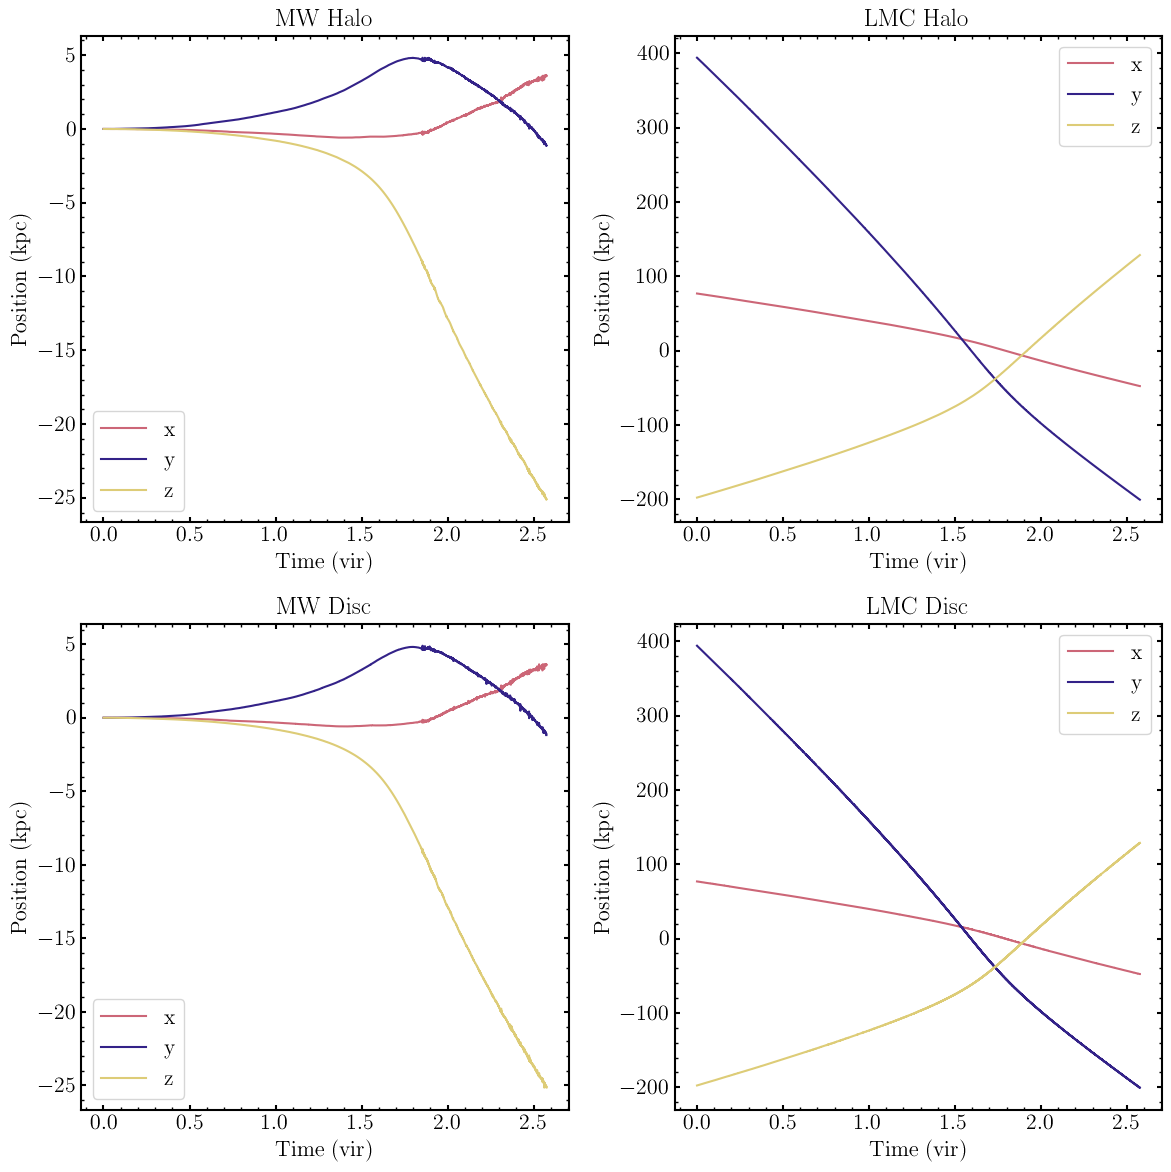

In [7]:
# plot centers over time

targetx = np.array([-0.61436097, -41.02036742, -26.83297465])


fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].plot(mwhcenter['t'], mwhcenter['x']*virialradius, label='x')
ax[0, 0].plot(mwhcenter['t'], mwhcenter['y']*virialradius, label='y')
ax[0, 0].plot(mwhcenter['t'], mwhcenter['z']*virialradius, label='z')
ax[0, 0].set_title('MW Halo')
ax[0, 0].set_xlabel('Time (vir)')
ax[0, 0].set_ylabel('Position (kpc)')
ax[0, 0].legend()
ax[0, 1].plot(lmchcenter['t'], lmchcenter['x']*virialradius, label='x')
ax[0, 1].plot(lmchcenter['t'], lmchcenter['y']*virialradius, label='y')
ax[0, 1].plot(lmchcenter['t'], lmchcenter['z']*virialradius, label='z')
# for i, target in enumerate(targetx):
#     ax[0, 1].axhline(target, color=f'C{i}', linestyle='--')
ax[0, 1].set_title('LMC Halo')
ax[0, 1].set_xlabel('Time (vir)')
ax[0, 1].set_ylabel('Position (kpc)')
ax[0, 1].legend()
ax[1, 0].plot(mwdcenter['t'], mwdcenter['x']*virialradius, label='x')
ax[1, 0].plot(mwdcenter['t'], mwdcenter['y']*virialradius, label='y')
ax[1, 0].plot(mwdcenter['t'], mwdcenter['z']*virialradius, label='z')
ax[1, 0].set_title('MW Disc')
ax[1, 0].set_xlabel('Time (vir)')
ax[1, 0].set_ylabel('Position (kpc)')
ax[1, 0].legend()
ax[1, 1].plot(lmcdcenter['t'], lmcdcenter['x']*virialradius, label='x')
ax[1, 1].plot(lmcdcenter['t'], lmcdcenter['y']*virialradius, label='y')
ax[1, 1].plot(lmcdcenter['t'], lmcdcenter['z']*virialradius, label='z')
# for i, target in enumerate(targetx):
#     ax[1, 1].axhline(target, color=f'C{i}', linestyle='--')
ax[1, 1].set_title('LMC Disc')
ax[1, 1].set_xlabel('Time (vir)')
ax[1, 1].set_ylabel('Position (kpc)')
ax[1, 1].legend()
plt.tight_layout()
plt.show()


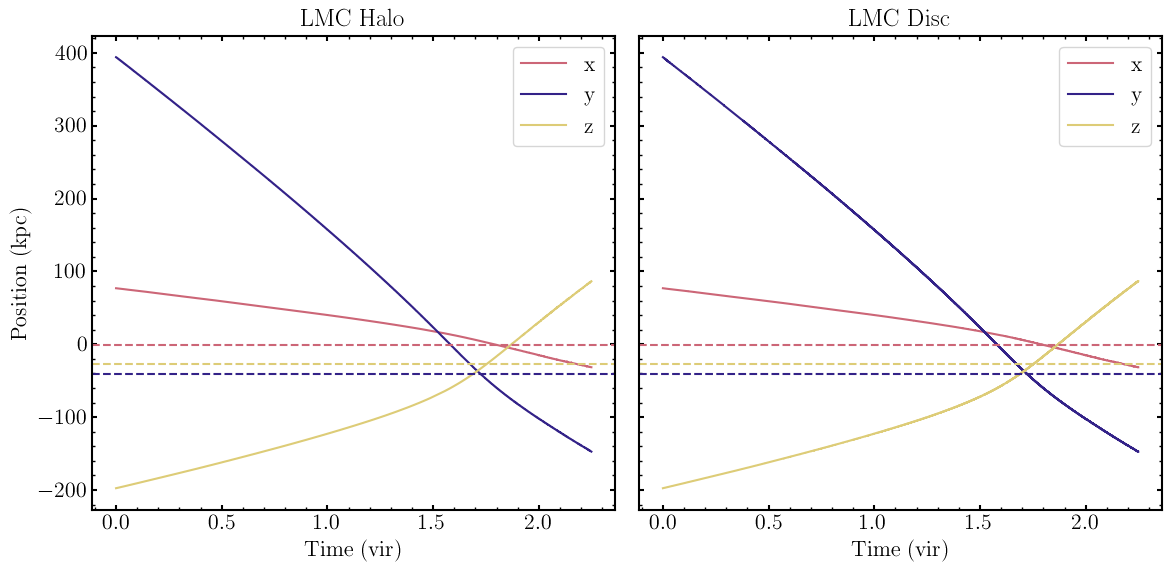

In [22]:
targetx = np.array([-0.61436097, -41.02036742, -26.83297465])


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].plot(lmchcenter['t'], (lmchcenter['x']-mwdcenter['x'])*virialradius, label='x')
ax[0].plot(lmchcenter['t'], (lmchcenter['y']-mwdcenter['y'])*virialradius, label='y')
ax[0].plot(lmchcenter['t'], (lmchcenter['z']-mwdcenter['z'])*virialradius, label='z')
for i, target in enumerate(targetx):
    ax[0].axhline(target, color=f'C{i}', linestyle='--')
ax[0].set_title('LMC Halo')
ax[0].set_xlabel('Time (vir)')
ax[0].set_ylabel('Position (kpc)')
ax[0].legend()
ax[1].plot(lmcdcenter['t'], (lmcdcenter['x']-mwdcenter['x'])*virialradius, label='x')
ax[1].plot(lmcdcenter['t'], (lmcdcenter['y']-mwdcenter['y'])*virialradius, label='y')
ax[1].plot(lmcdcenter['t'], (lmcdcenter['z']-mwdcenter['z'])*virialradius, label='z')
for i, target in enumerate(targetx):
    ax[1].axhline(target, color=f'C{i}', linestyle='--')
ax[1].set_title('LMC Disc')
ax[1].set_xlabel('Time (vir)')
# ax[1].set_ylabel('Position (kpc)')
ax[1].legend()
plt.tight_layout()
plt.show()

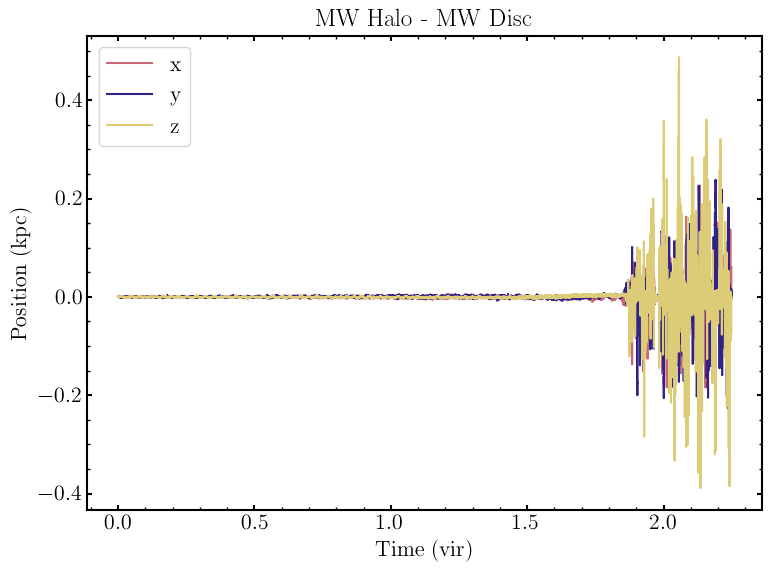

In [23]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
ax.plot(mwhcenter['t'], (mwhcenter['x']-mwdcenter['x'])*virialradius, label='x')
ax.plot(mwhcenter['t'], (mwhcenter['y']-mwdcenter['y'])*virialradius, label='y')
ax.plot(mwhcenter['t'], (mwhcenter['z']-mwdcenter['z'])*virialradius, label='z')
ax.set_title('MW Halo - MW Disc')
ax.set_xlabel('Time (vir)')
ax.set_ylabel('Position (kpc)')
ax.legend()

plt.tight_layout()
plt.show()

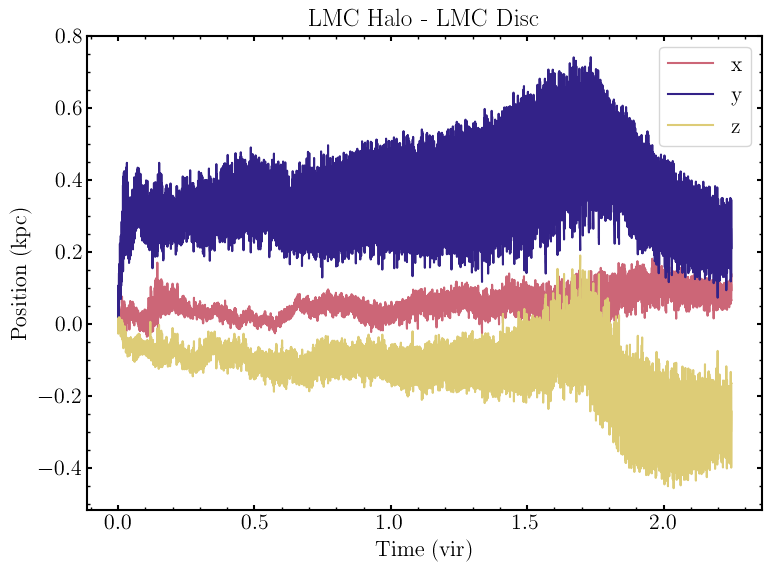

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
ax.plot(lmchcenter['t'], (lmchcenter['x']-lmcdcenter['x'])*virialradius, label='x')
ax.plot(lmchcenter['t'], (lmchcenter['y']-lmcdcenter['y'])*virialradius, label='y')
ax.plot(lmchcenter['t'], (lmchcenter['z']-lmcdcenter['z'])*virialradius, label='z')
ax.set_title('LMC Halo - LMC Disc')
ax.set_xlabel('Time (vir)')
ax.set_ylabel('Position (kpc)')
ax.legend()

plt.tight_layout()
plt.show()

In [25]:
def return_euler_slater(phi, theta, psi, derotate=False):
    euler = np.zeros((3,3))

    sph = np.sin(phi)
    cph = np.cos(phi)
    sth = np.sin(theta)
    cth = np.cos(theta)
    sps = np.sin(psi)
    cps = np.cos(psi)
    
    euler[0, 0] = -sps*sph + cth*cph*cps
    euler[0, 1] =  sps*cph + cth*sph*cps
    euler[0, 2] =  cps*sth
        
    euler[1, 0] = -cps*sph - cth*cph*sps
    euler[1, 1] =  cps*cph - cth*sph*sps
    euler[1, 2] = -sps*sth
        
    euler[2, 0] = -sth*cph
    euler[2, 1] = -sth*sph
    euler[2, 2] =  cth

    if derotate:
        return euler.transpose()
    else:
        return euler


In [26]:
print("Test whether all coef times are the same and whether they are in the center times")
print("All coef times are the same:", mwhcoefs.Times() == lmchcoefs.Times() == mwdcoefs.Times() == lmcdcoefs.Times())
print("Coef times are in orient file times:", all([time in mwhcenter['t'] for time in mwhcoefs.Times()[1:]]))
print("Coef time 0.0 is not in the orient files  ")

Test whether all coef times are the same and whether they are in the center times
All coef times are the same: True
Coef times are in orient file times: True
Coef time 0.0 is not in the orient files  


### Full simulation movie


Created fields instance


/var/folders/47/zhpl4bzx44s4_05_ht2zctlc0000gn/T/ipykernel_45131/3337811219.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmin_tmp  = [0.0, float(-size-lmchcenter_tmp[1]),  float(-size-lmchcenter_tmp[2])]
/var/folders/47/zhpl4bzx44s4_05_ht2zctlc0000gn/T/ipykernel_45131/3337811219.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmax_tmp  = [0.0, float(size-lmchcenter_tmp[1]), float(size-lmchcenter_tmp[2])]


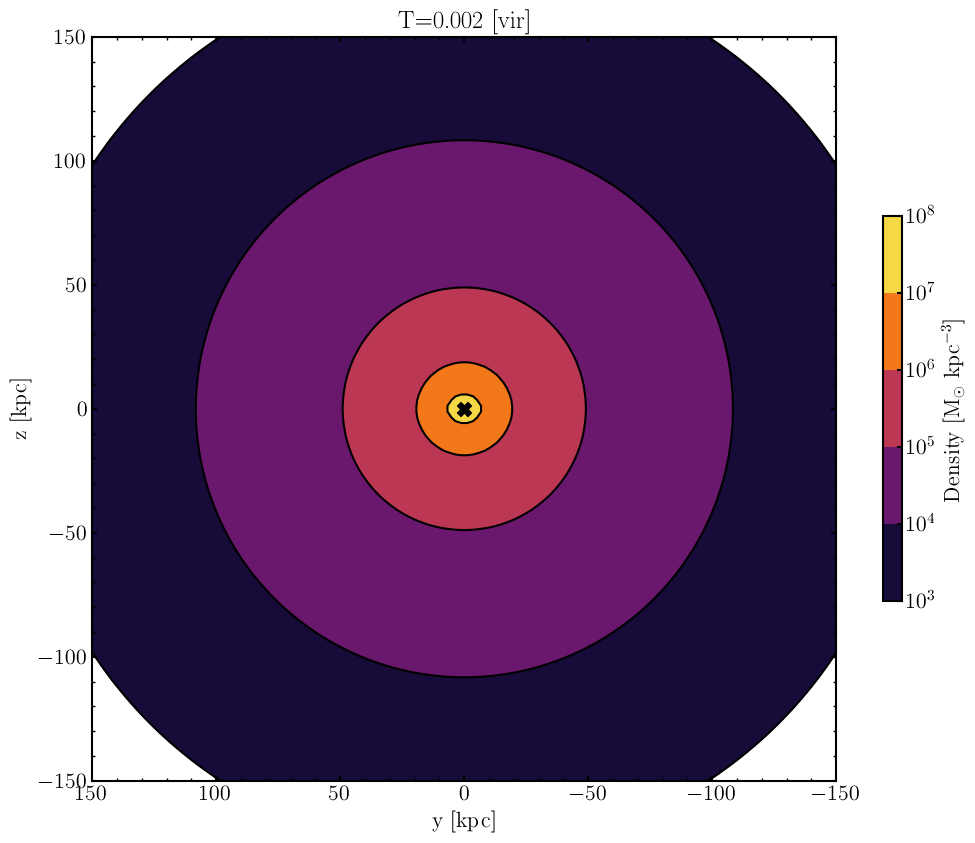

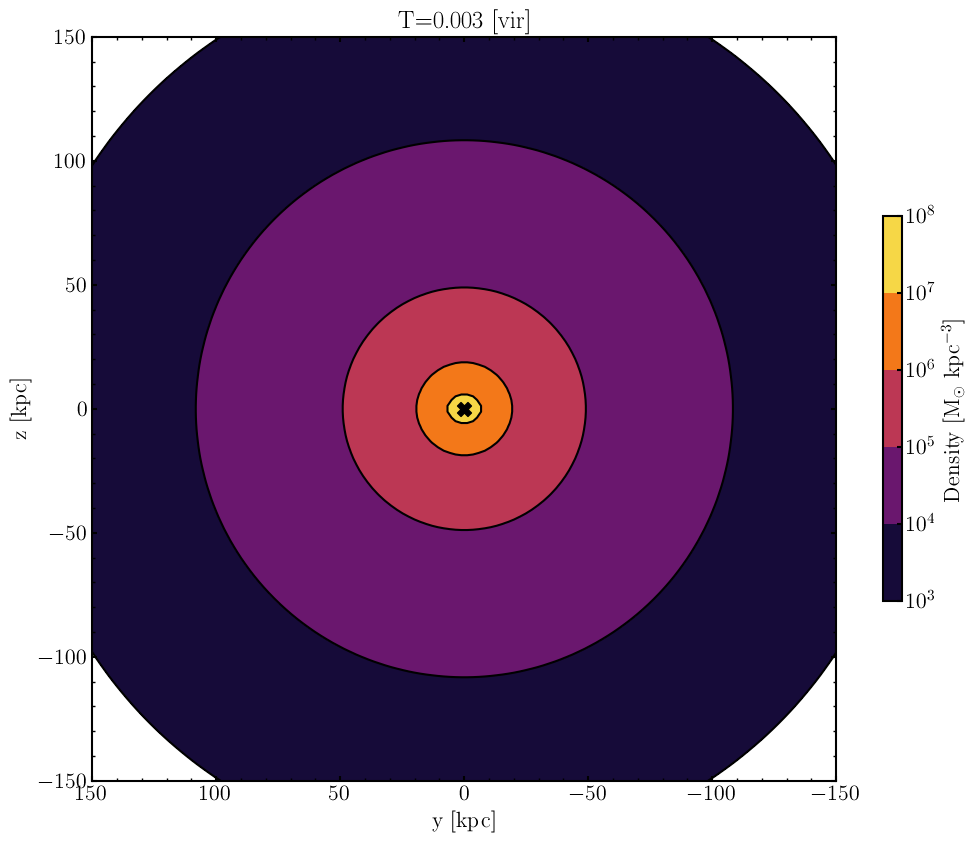

KeyboardInterrupt: 

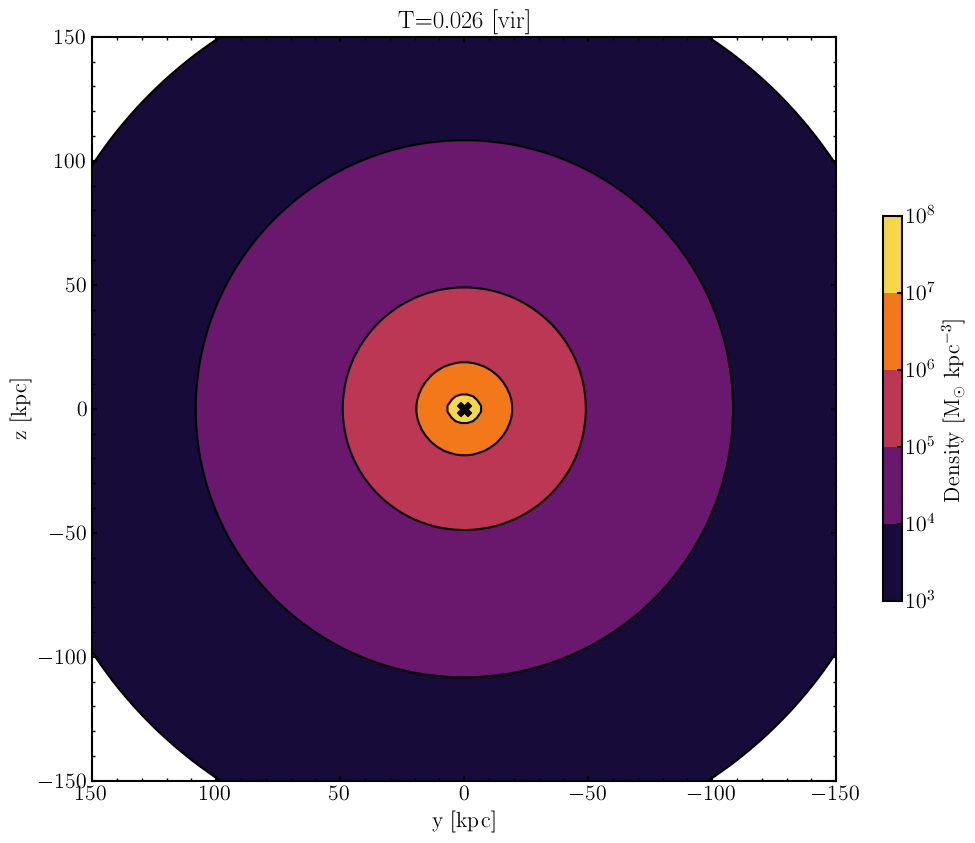

In [27]:
size = 150./virialradius
npix = 128

times = mwhcoefs.Times()
pmin  = [0.0, -size,  -size]
pmax  = [0.0, size, size]
grid  = [ 0,  npix,  npix]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

# lmc_pmin  = [-size, 0.0, -size]
# lmc_pmax  = [ size, 0.0, size]
# lmchfields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

mwhsurfaces = fields.slices(mwhbasis, mwhcoefs)

mwhkeys = list(mwhsurfaces.keys())
nx = mwhsurfaces[mwhkeys[0]]['dens'].shape[0]
ny = mwhsurfaces[mwhkeys[0]]['dens'].shape[1]


# Make the mesh
x = np.linspace(pmin[1], pmax[1], nx)
y = np.linspace(pmin[2], pmax[2], ny)
xv, yv = np.meshgrid(x, y)

# plt.rcParams.update({'font.size': 22})

# Fix the contour levels to prevent jitter in the movie
cbar1 = 10**np.arange(0.0, 4.01, 0.1)
cbar2 = 10**np.arange(0.0, 4.01, 0.4)

# Frame counter
icnt = 0
cmap = sns.color_palette("rocket", as_cmap=True)


N = cmap.N
cmap.set_under(cmap(1))
cmap.set_over(cmap(N-1))
densmin = 1e5
densmax = 1
vmin=1e3
vmax=1e8
levels = np.logspace(3,8,endpoint=True,num=6)

# Iterate through the keys
for time in mwhkeys:
    if time == 0.0: continue
    # time=0.76
    if time > 1.8: break # stop shortly past pericentre
    # if os.path.isfile(f'movies/mwlmchaloes/{runtag}_movie_{icnt:04d}_xz.png'):
    #     icnt += 1
    #     continue
    tmask = mwhcenter['t'] == time
    if sum(tmask) > 1: 
        tmask[np.where(tmask)[0][1:]]=False
    mwhcenter_tmp = np.array([mwhcenter['x'][tmask], mwhcenter['y'][tmask], mwhcenter['z'][tmask]])
    lmchcenter_tmp = np.array([lmchcenter['x'][tmask], lmchcenter['y'][tmask], lmchcenter['z'][tmask]])
    
    # print(lmchcenter_tmp)
    #make lmc field 
    pmin_tmp  = [0.0, float(-size-lmchcenter_tmp[1]),  float(-size-lmchcenter_tmp[2])]
    pmax_tmp  = [0.0, float(size-lmchcenter_tmp[1]), float(size-lmchcenter_tmp[2])]
    lmcfields = pyEXP.field.FieldGenerator([time], pmin_tmp, pmax_tmp, grid)
    lmchsurface = lmcfields.slices(lmchbasis, lmchcoefs)

    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    
    mwhmat = mwhsurfaces[time]['dens'] * massscale / pow(virialradius,3)

    lmchmat = lmchsurface[time]['dens'] * massscale / pow(virialradius,3)
    
    mat = mwhmat + lmchmat
    
    
    # tab = pd.pivot_table(dfdens, values = 'dens', index=['z'], columns = ['y'],  aggfunc=np.sum)

    # update min and max densities
    if densmin > np.min(mat): densmin = np.min(mat)
    if densmax < np.max(mat): densmax = np.max(mat)
    
    # for i in range(mat.shape[0]):
    #     for j in range(mat.shape[1]):
    #         if mat[i, j] < 1.0: mat[i, j] = 1.0
    #         if mat[i, j] > 10000.0: mat[i, j] = 10000.0
            
    cont1 = ax.contour(xv*virialradius, yv*virialradius, mat.transpose(), levels, colors='k', norm=colors.LogNorm())
    # You can label the contours inline by uncommenting the next two lines...
    # ax[0].clabel(cont1, fontsize=9, inline=True)
    # cont2 = ax.contourf(xv, yv, surfaces[time]['d'].transpose(), cbar2, vmin=cbar2[0], vmax=cbar2[-1])
    cont2 = ax.contourf(xv*virialradius, yv*virialradius, mat.transpose(),levels, norm=colors.LogNorm()) #locator=ticker.LogLocator()
    ax.set_xlabel('y [kpc]')
    ax.set_ylabel('z [kpc]')
    ax.set_title('T={:4.3f} [vir]'.format(time))
    ax.scatter([0],[0], marker='X', s=100, color='k')
    ax.invert_xaxis()
    cbar = fig.colorbar(cont2, ax=ax, shrink=0.5, extend='both')
    cbar.set_label('Density [M$_\odot$ kpc$^{-3}$]')
    ax.set_aspect('equal')
    fig.savefig(f'movies/mwlmchaloes/{runtag}_movie_{icnt:04d}_xz.png', dpi=256, bbox_inches='tight')
    if icnt < 2:
        plt.show()
    else:
        plt.close()

    icnt += 1
    # break
    
    





### MW and LMC halo


<>:79: SyntaxWarning: invalid escape sequence '\o'
<>:79: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2109255/1831210022.py:79: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('Density [M$_\odot$ kpc$^{-3}$]')
/tmp/ipykernel_2109255/1831210022.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmin_tmp  = [0.0, float(-size-lmchcenter_tmp[1]),  float(-size-lmchcenter_tmp[2])]
/tmp/ipykernel_2109255/1831210022.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmax_tmp  = [0.0, float(size-lmchcenter_tmp[1]), float(size-lmchcenter_tmp[2])]
/tmp/ipykernel_2109255/1831210022.py:71: UserWarning: The following kwa

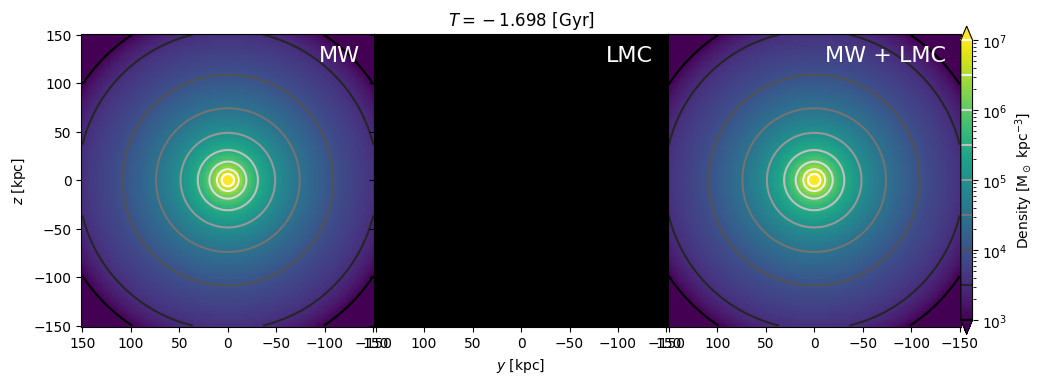

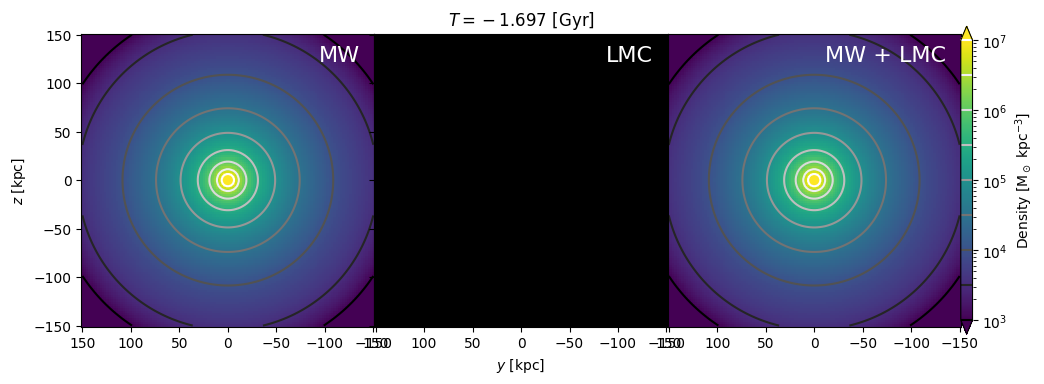

/tmp/ipykernel_2109255/1831210022.py:79: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('Density [M$_\odot$ kpc$^{-3}$]')


KeyboardInterrupt: 

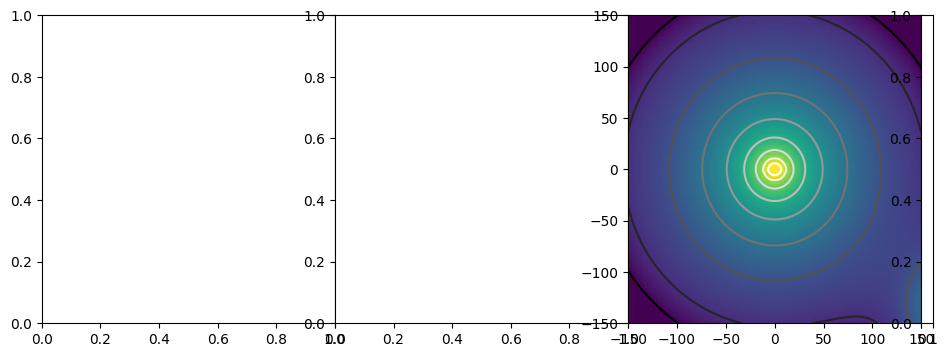

In [ ]:
size = 150./virialradius
npix = 128

times = mwhcoefs.Times()
pmin  = [0.0, -size,  -size]
pmax  = [0.0, size, size]
grid  = [ 0,  npix,  npix]

# make MW fields (LMC fields are shifted by its center at each time step in the for loop)
fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)
mwhsurfaces = fields.slices(mwhbasis, mwhcoefs)

mwhkeys = list(mwhsurfaces.keys())
nx = mwhsurfaces[mwhkeys[0]]['dens'].shape[0]
ny = mwhsurfaces[mwhkeys[0]]['dens'].shape[1]


# Make the mesh
x = np.linspace(pmin[1], pmax[1], nx)
y = np.linspace(pmin[2], pmax[2], ny)
xv, yv = np.meshgrid(x, y)


# Frame counter
icnt = 0
cmap = sns.color_palette("rocket", as_cmap=True)


N = cmap.N
cmap.set_under(cmap(1))
cmap.set_over(cmap(N-1))
densmin = 1e5
densmax = 1
vmin=1e3
vmax=1e7
levels = np.logspace(3,7,endpoint=True,num=9)

tref = 1.7

# Iterate through the keys
for time in mwhkeys:
    if time == 0.0: continue
    # time=1.76
    if time > tref: break # stop shortly past pericentre
    # if os.path.isfile(f'movies/mwlmchaloes/{runtag}_movie_{icnt:04d}_xz.png'):
    #     icnt += 1
    #     continue
    tmask = mwhcenter['t'] == time
    if sum(tmask) > 1: 
        tmask[np.where(tmask)[0][1:]]=False
    mwhcenter_tmp = np.array([mwhcenter['x'][tmask], mwhcenter['y'][tmask], mwhcenter['z'][tmask]])
    lmchcenter_tmp = np.array([lmchcenter['x'][tmask], lmchcenter['y'][tmask], lmchcenter['z'][tmask]])
    
    # print(lmchcenter_tmp)
    #make lmc field 
    pmin_tmp  = [0.0, float(-size-lmchcenter_tmp[1]),  float(-size-lmchcenter_tmp[2])]
    pmax_tmp  = [0.0, float(size-lmchcenter_tmp[1]), float(size-lmchcenter_tmp[2])]
    lmcfields = pyEXP.field.FieldGenerator([time], pmin_tmp, pmax_tmp, grid)
    lmchsurface = lmcfields.slices(lmchbasis, lmchcoefs)

    # fig, ax = plt.subplots(1, 1, figsize=(12,10))
    fig, (ax0, ax1, ax2, cax) = plt.subplots(ncols=4, figsize=(11.5, 4), gridspec_kw={"width_ratios":[1,1,1,0.04], 'wspace': 0.0})

    
    mwhmat = mwhsurfaces[time]['dens'] * massscale / pow(virialradius,3)
    lmchmat = lmchsurface[time]['dens'] * massscale / pow(virialradius,3)
    mat = mwhmat + lmchmat
    
    # full density
            
    cont1 = ax2.contour(xv*virialradius, yv*virialradius, mat.transpose(), levels, norm=colors.LogNorm(), cmap=plt.cm.Greys_r, lw=2)
    cont2 = ax2.pcolormesh(xv*virialradius, yv*virialradius, mat.transpose(),norm=colors.LogNorm(vmin=vmin, vmax=vmax)) #locator=ticker.LogLocator()

    ax2.text(0.95, 0.925, 'MW + LMC', horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, c= 'white', fontsize = 16)
    ax2.tick_params(labelleft=False)
    ax2.invert_xaxis()
    
    cbar = fig.colorbar(cont2, cax=cax, extend='both')
    cbar.set_label('Density [M$_\odot$ kpc$^{-3}$]')
    cbar.add_lines(cont1)

    ax2.set_aspect('equal')
    ax2.set_facecolor('k')

    
    # lmc density
    cont1 = ax1.contour(xv*virialradius, yv*virialradius, lmchmat.transpose(), levels, norm=colors.LogNorm(), cmap=plt.cm.Greys_r, lw=2)
    cont2 = ax1.pcolormesh(xv*virialradius, yv*virialradius, lmchmat.transpose(),norm=colors.LogNorm(vmin=vmin, vmax=vmax)) #locator=ticker.LogLocator()
    ax1.set_aspect('equal')
    ax1.set_title('$T={:4.3f}$ [Gyr]'.format(time-tref))
    ax1.set_xlabel('$y$ [kpc]')
    ax1.text(0.95, 0.925, 'LMC', horizontalalignment='right', verticalalignment='center', transform=ax1.transAxes, c= 'white', fontsize = 16)
    ax1.tick_params(labelleft=False)
    ax1.invert_xaxis()
    ax1.set_facecolor('k')

    # MW density
    cont1 = ax0.contour(xv*virialradius, yv*virialradius, mwhmat.transpose(), levels, norm=colors.LogNorm(), cmap=plt.cm.Greys_r, lw=2)
    cont2 = ax0.pcolormesh(xv*virialradius, yv*virialradius, mwhmat.transpose(),norm=colors.LogNorm(vmin=vmin, vmax=vmax)) #locator=ticker.LogLocator()    
    ax0.set_aspect('equal')
    ax0.text(0.95, 0.925, 'MW', horizontalalignment='right', verticalalignment='center', transform=ax0.transAxes, c= 'white', fontsize = 16)
    ax0.set_ylabel("$z$ [kpc]")
    ax0.invert_xaxis()
    ax0.set_facecolor('k')
    
    # save and continue
    # fig.savefig(f'movies/mwlmchaloes/{runtag}_movie_{icnt:04d}_xz.png', dpi=256, bbox_inches='tight')
    if icnt < 2:
        plt.show()
    else:
        plt.close()

    icnt += 1
    # break
    
    


In [12]:
import cv2 as cv

### this function sorts your input files numerically (0,1,,...9,10,11...99, 100,...)
def sorted_nicely( l ):
    """Sorts the given iterable in the way that is expected.
        Required arguments:
        l -- The iterable to be sorted
    """

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)
    
### prepare file list and load images
    
# read in files
files = [f for f in glob.glob(f'./movies/mwlmchaloes/{runtag}_*.png', recursive=True)] # images saved as png
files = sorted_nicely(files)

files = files[624:]

img = cv.imread(cv.samples.findFile(files[0]))
rows, cols = img.shape[:2]


fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(f'movies/mwlmchaloes_{runtag}_yz.mp4', fourcc, 20.0, (cols, rows))
out2 = cv.VideoWriter(f'movies/mwlmchaloes_{runtag}_yz.avi', fourcc, 20.0, (cols, rows))

for file in files:
    img = cv.imread(cv.samples.findFile(file))
    rows, cols = img.shape[:2]
    out.write(img)
    out2.write(img)
     
out.release() 
out2.release() 
     


In [11]:
files[624]

'./movies/mwlmchaloes/RunG5n_movie_0281_xz.png'

In [196]:
tmask[np.where(tmask)[0][1:]]=False


In [228]:
levels

array([1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07, 3.16227766e+07, 1.00000000e+08])

In [227]:
levels = np.logspace(3,8,endpoint=True,num=11)


In [83]:
mwhkeys = list(mwhsurfaces.keys())
nx = mwhsurfaces[mwhkeys[0]]['dens'].shape[0]
ny = mwhsurfaces[mwhkeys[0]]['dens'].shape[1]


# Make the mesh
x = np.linspace(pmin[1], pmax[1], nx)
y = np.linspace(pmin[2], pmax[2], ny)
xv, yv = np.meshgrid(x, y)


/var/folders/47/zhpl4bzx44s4_05_ht2zctlc0000gn/T/ipykernel_74523/403716794.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  cf = plt.contourf((xv+lmchcenter['y'][maskt])*virialradius,


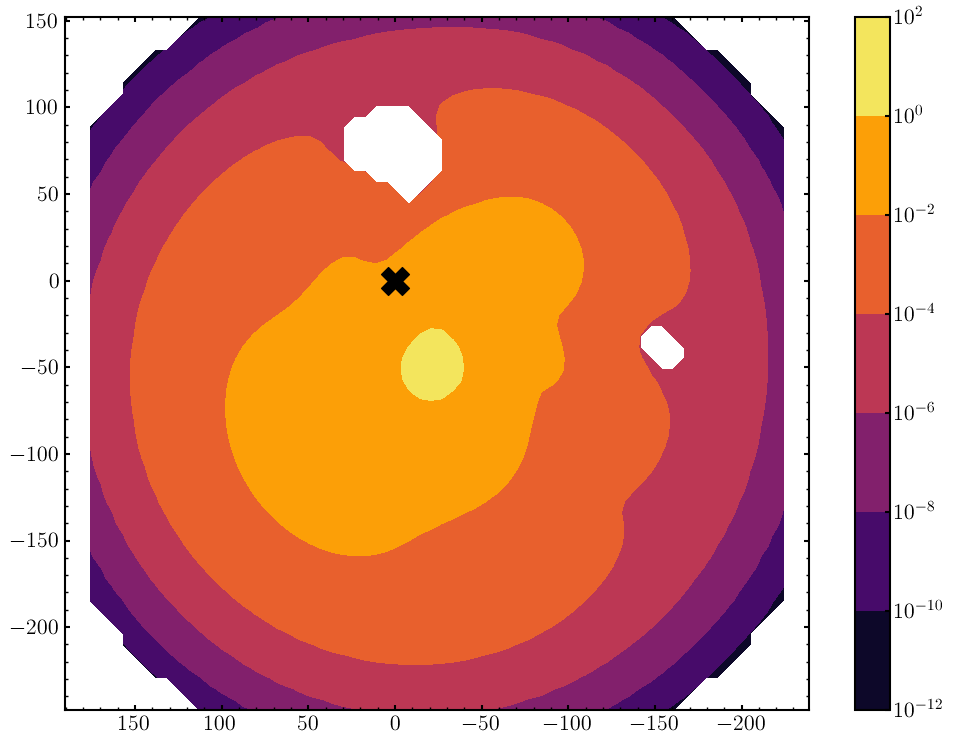

In [107]:
test_time = 1.68
maskt = mwhcenter['t'] == test_time
cf = plt.contourf((xv+lmchcenter['y'][maskt])*virialradius, 
             (yv+lmchcenter['z'][maskt])*virialradius, 
             lmchsurfaces[test_time]['dens'].transpose(), 
             norm=colors.LogNorm())
plt.scatter([0],[0], marker='X', s=400, color='k')
plt.gca().invert_xaxis()
plt.axis('equal')
plt.colorbar(cf)

In [111]:
lmcfields = pyEXP.field.FieldGenerator([times[100]], pmin, pmax, grid)
lmchsurface = lmcfields.slices(lmchbasis, lmchcoefs)


In [114]:
lmchsurface.keys()

dict_keys([0.16])

In [115]:
times[100]

0.16

Docstring:
volumes(self: pyEXP.field.FieldGenerator, arg0: pyEXP.basis.Basis, arg1: pyEXP.coefs.Coefs) -> Dict[float, Dict[str, numpy.ndarray[numpy.float32]]]


Volume grids (3d numpy arrays) indexed by time and field type

Parameters
----------
basis : Basis
    basis instance of any geometry; geometry will be deduced by the generator
coefs : Coefs
    coefficient container instance

Returns
-------
dict({time: {field-name: numpy.ndarray})
    dictionary of times, field names, and data arrays

Notes
-----
Each data array in the dictionary is a volume with the range given
by the constructor.

See also
--------
lines : generate fields along a line given by its end points
slices : generate fields in a slice given by the initializtion grid
Type:      method